In [1]:
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

image_dir = "./images"
label_dir = "./labels"

images = glob(os.path.join(image_dir, '*.png'))
labels = glob(os.path.join(label_dir, '*.png'))

In [2]:
tags = {0:None, 1:"Buildings", 2:"Fences",3:"Other",4:"Pedestrians",5:"Poles",
         6:"RoadLines",7:"Roads",8:"Sidewalks",9:"Vegetation",10:"Vehicles",11:"Walls",12:"TrafficSigns"}
total_images = len(images)
total_labels = len(labels)
print("Total images:", total_images)
print("Total labels:", total_labels)

Total images: 1000
Total labels: 1000


In [3]:
# creating data object
d = {'image':images, 'label':labels}
columns = ['image', 'label']
data = pd.DataFrame(d, columns=columns)

In [4]:
def crop(img):
    img_copy = np.copy(img)
    #img_copy = cv2.resize(img_copy, (400,300))
    img_copy = img_copy[100:500,:]
    return img_copy

In [5]:
idx = np.random.randint(total_images)
image = cv2.imread(images[idx])
label = cv2.imread(labels[idx])[:,:,2]

image = crop(image)
label = crop(label)

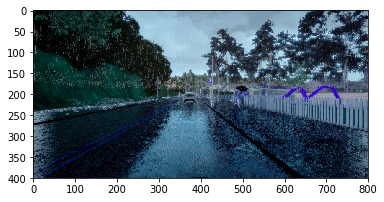

In [6]:
plt.imshow(image)

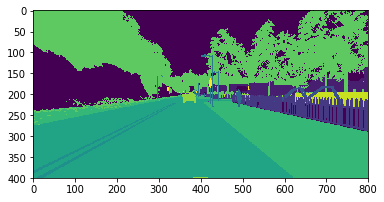

In [7]:
plt.imshow(label)

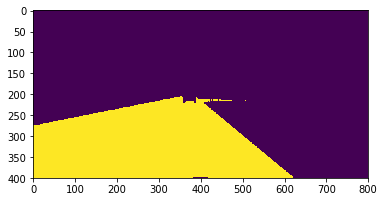

In [8]:
label[label == 6] = 7
lb_road = np.zeros_like(label)
lb_road[label == 7] = 1
plt.imshow(lb_road)

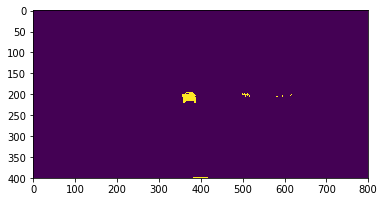

In [9]:
lb_car = np.zeros_like(label)
lb_car[label == 10] = 1
plt.imshow(lb_car)

In [10]:
lb_car

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [11]:
final_label = np.array([lb_road, lb_car])

In [12]:
final_label.shape

(2, 400, 800)

In [13]:
image.shape

(400, 800, 3)

In [14]:
a = np.zeros((400,800,2))
a[:,:,0] = lb_road
a[:,:,1] = lb_car

In [276]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Sequential
from keras import initializers
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, Lambda, Conv2D, MaxPooling2D, Cropping2D, Dropout, BatchNormalization, Conv2DTranspose

# split training and validation data
#train_samples, validation_data = train_test_split(data, test_size=0.3)
#validation_samples, test_samples = train_test_split(validation_data, test_size=0.5)
train_samples = data

# define the generator
def generator(samples, batch_size = 32):
    num_samples = len(samples)
    while 1:
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            labels = []
            for ind, sample in batch_samples.iterrows():
                # center image
                image = cv2.imread(sample['image'])
                label = cv2.imread(sample['label'])[:,:,2]
                image = crop(image)
                label = crop(label)
                
                label[label == 6] = 7
                lb_road = np.zeros_like(label)
                lb_road[label == 7] = 1
                lb_car = np.zeros_like(label)
                lb_car[label == 10] = 1
                final_label = np.zeros((400,800,2))
                final_label[:,:,1] = lb_road
                final_label[:,:,0] = lb_car
                #print(final_label.shape)
                
                flipped_label = np.zeros((400,800,2))
                flipped_label[:,:,1] = cv2.flip(lb_road, 1)
                flipped_label[:,:,0] = cv2.flip(lb_car, 1)
                flipped_image = cv2.flip(image, 1)
                #flipped_label = cv2.flip(label, 1)
                
                images.append(image)
                labels.append(final_label)
                images.append(flipped_image)
                labels.append(flipped_label)
                
            X_train = np.array(images)
            y_train = np.array(labels)
            #print(X_train.shape)
            #print(y_train.shape)
            yield shuffle(X_train, y_train)

# define batch size and create the generators
batch_size = 8
train_generator = generator(train_samples, batch_size)
validation_generator = generator(validation_samples, batch_size)

In [ ]:
from keras import models
from keras.layers.core import Activation, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
import json

img_w = 800
img_h = 400
n_labels = 2

kernel = 3

encoding_layers = [
    Lambda(lambda x: x / 255.0 - 0.5, input_shape = (img_h, img_w, 3)),
    Conv2D(12, (kernel,kernel), padding='same', activation = "relu"),#, input_shape=( img_h, img_w,3)),
    BatchNormalization(),
    Conv2D(12, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(),

]

model = models.Sequential()
model.encoding_layers = encoding_layers
#model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (400, 800, 3)))
#model.add(Conv2D(64, (kernel,kernel), padding='same', activation = "relu"))
for l in model.encoding_layers:
    model.add(l)

decoding_layers = [

    UpSampling2D(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),

    UpSampling2D(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),

    UpSampling2D(),
    Conv2D(24, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(12, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),

    UpSampling2D(),
    Conv2D(12, (kernel,kernel), padding='same', activation = "relu"),
    BatchNormalization(),
    Conv2D(n_labels, 1, padding='valid', activation = "softmax"),
    BatchNormalization(),
]
#model.decoding_layers = decoding_layers
#for l in model.decoding_layers:
for l in decoding_layers:
    model.add(l)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_8 (Lambda)            (None, 400, 800, 3)       0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 400, 800, 12)      336       
_________________________________________________________________
batch_normalization_141 (Bat (None, 400, 800, 12)      48        
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 400, 800, 12)      1308      
_________________________________________________________________
batch_normalization_142 (Bat (None, 400, 800, 12)      48        
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 200, 400, 12)      0         
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 200, 400, 24)      2616      
__________

In [ ]:
model.compile(loss = 'mse', optimizer = 'adam')
stats = model.fit_generator(train_generator, steps_per_epoch= len(train_samples)/batch_size, validation_data=validation_generator, validation_steps=len(validation_samples)/batch_size, epochs=100)


Epoch 1/100
100/125 [=======================>......] - ETA: 22s - loss: 0.6816

Cell for time calculation:

90.6 ms ± 48.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


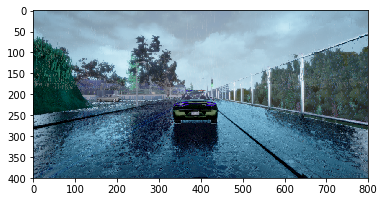

In [263]:
%%timeit

test_img  = cv2.imread(test_samples.iloc[12]['image'])
test_img = crop(test_img)
plt.imshow(test_img)
test_img = np.expand_dims(test_img, axis=0)

pred = model.predict(test_img)
pred = pred[0]
car_pred = pred[:,:,0]
car_output = np.zeros((400,800), dtype=np.uint8)
car_output[car_pred < 0] = 1.0

road_pred = pred[:,:,1]
road_output = np.zeros((400,800), dtype=np.uint8)
road_output[road_pred < 0] = 1.0

42~ ms. Since my GPU is roughly equal to Tesla K80, this must run at 20+ FPS.

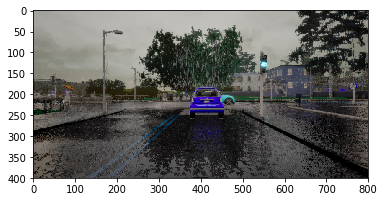

In [264]:
img = test_samples.iloc[148]
test_img  = cv2.imread(img['image'])
test_img = crop(test_img)
plt.imshow(test_img)
test_img = np.expand_dims(test_img, axis=0)

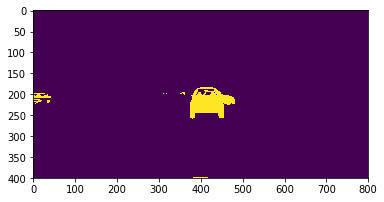

In [265]:
test_lbl  = cv2.imread(img['label'])[:,:,2]
test_lbl = crop(test_lbl)
test_lbl[test_lbl != 10] = 0
plt.imshow(test_lbl)

In [266]:
#test_img = np.expand_dims(test_img, axis=0)
pred = model.predict(test_img)
pred = pred[0]
pred.shape

(400, 800, 2)

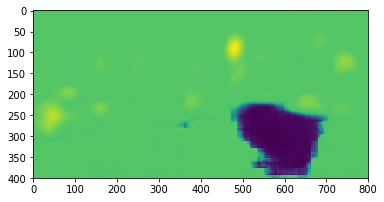

In [267]:
pp = pred[:,:,0]
plt.imshow(pp)

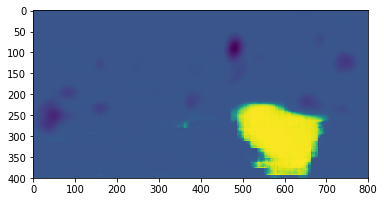

In [268]:
pp1 = pred[:,:,1]
plt.imshow(pp1)

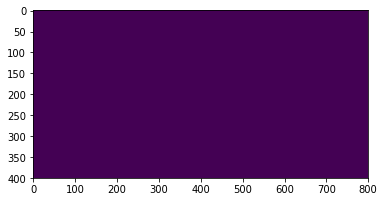

In [269]:
yy = np.zeros((400,800), dtype=np.uint8)
yy[pp < 0] = 1.0
plt.imshow(yy)

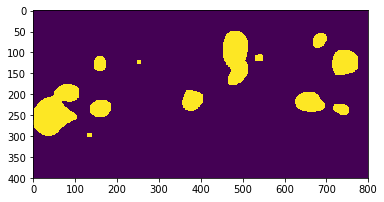

In [270]:
opening = np.zeros((400,800), dtype=np.uint8)
opening[pp1 < 0.02] = 1.0
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(opening, cv2.MORPH_OPEN, kernel)
#plt.imshow(opening)
opening = cv2.dilate(opening,kernel,iterations = 3)
plt.imshow(opening)

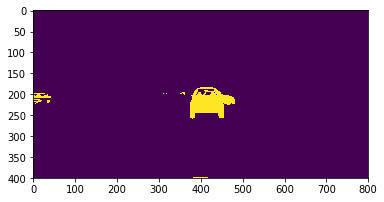

In [271]:
plt.imshow(test_lbl)

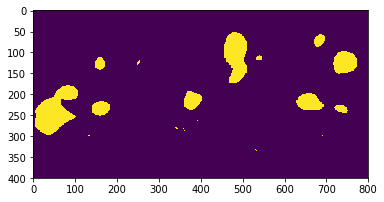

In [272]:
zz1 = np.zeros((400,800), dtype=np.uint8)
zz1[pp1 < 0.02] = 1.0
plt.imshow(zz1)

In [216]:
model.save("model_best.m5")